In [ ]:
############# Complete pipeline for DATA Processing and Graph classification ##############

In [2]:
# N-hop proposals (Graph) classification using GAT and globalATTPooling

import os,sys,inspect
import joblib
import tensorflow as tf
import numpy as np
import h5py
import scipy.sparse.linalg as la
import scipy.sparse as sp
import scipy
import time
import pickle
import random
import datetime
from sklearn.utils import shuffle
from _datetime import datetime
import pickle
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense, Flatten, Activation, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
from scipy.sparse import csr_matrix

import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from spektral.layers import GATConv, GlobalAttentionPool, GlobalSumPool
from spektral.layers.pooling import TopKPool, MinCutPool

# import graph
# import coarsening
# import utils

#import sys  
#sys.path.insert(0, '/home/sachin/PycharmProjects/spektral_graph')

from utility.Fetch_Prop_graph import Fetch_graph
from utility.binaryProcessing import nclass_to_binclass
tf.test.is_gpu_available()

Layer 0: M_0 = |V| = 16384 nodes (0 added), |E| = 33023 edges
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [18]:
### Use tensorflow api for augmentation
def augmentation(sample):
    lef_right = tf.image.flip_left_right(sample)
    up_down = tf.image.flip_up_down(sample)
    rot_90 = tf.image.rot90(sample, k=1)
    rot_180 = tf.image.rot90(sample, k=2)
    rot_270 = tf.image.rot90(sample, k=3)
    aug = [sample, lef_right, up_down, rot_90, rot_180, rot_270]
    return aug


In [ ]:
########################################################################################
~~~~~~~~~~~~~~~~~~~~~~~~~~ DATA Preprocessing ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
########################################################################################

In [19]:
from sklearn.model_selection import KFold
from skimage.measure import label
import scipy.misc
import imageio
import cv2, glob, re
from PIL import Image
import os, random
from utility.Create_patches import sliding_window
from utility.BFS_ver2 import main

patch_size = 128
IMAGE_SHAPE = [patch_size,patch_size]   # H x W
nhop = 20

def delta(contours):
    ctr = []
    ctr.clear()
    dlt = []
    dlt.clear()
    for i in range(0, len(contours)):
        cnt = contours[i]
        # find centre of the contours
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            # set values as what you need in the situation
            cx, cy = 0, 0
        centre = (cx, cy)
        if cy != 0:
            d = ((cy - 1) * patch_size) + cx
        else:
            d = cx
        ctr.append(centre)
        dlt.append(d)
    return dlt

# Data Preprocessing
data_folder = "/home/sachin/PycharmProjects/Segmentation_GCNN/Training_data"

image_paths = glob.glob(os.path.join(data_folder, 'Images', '*.tif'))
label_paths = {
            re.sub(r'.Label.png', '', os.path.basename(path)): path
            for path in glob.glob(os.path.join(data_folder, 'Label', '*.png'))}
        # background_color = np.array([255, 0, 0])
   
random.shuffle(image_paths)

#image_paths = "/home/sachin/PycharmProjects/Segmentation_GCNN/Training_data/Images/TMA1_A1.tif"

windowSize = (patch_size, patch_size)
stepSize = patch_size+1

ALL_image_patches = []
ALL_label_patches = []
ALL_label_mask = []
All_label_delta = []
for image_read in image_paths[0:len(image_paths)]:
    if image_read == "/home/sachin/PycharmProjects/Segmentation_GCNN/Training_data/Images/TMA1_A1.tif" :
        print("image_read",image_read)
        image = np.array(Image.open(image_read))
        # noise removal
#         image = cv2.imread(image_read)
#         image_noise = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)
#         cv2.imshow('image',image_noise)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()


        #grayscaled = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
      
        # Otsu's thresholding after Gaussian filtering
        #blur = cv2.GaussianBlur(grayscaled,(7,7),0)
        #ret3,image = cv2.threshold(blur,0,255,cv2.THRESH_TRUNC+cv2.THRESH_OTSU)

        #image_noise = cv2.fastNlMeansDenoisingColored(image,None,200,200,5,13)
        #ret,image = cv2.threshold(image_noise,205,255,cv2.THRESH_BINARY)
        
        gt_image_file = label_paths[os.path.basename(image_read)]
        gt_image = np.array(Image.open(gt_image_file))

        image_patches = []
        for (x, y, window) in sliding_window(image, stepSize, windowSize):
                if window.shape == (patch_size, patch_size, 3):
                    window_ = tf.reshape(augmentation(window), [-1,128,128,3])
                    for aug in window_:
                        image_patches.append(aug)

        label_patches = []
        label_mask = []
        label_delta = []
        for (x, y, window) in sliding_window(gt_image, stepSize, windowSize):
                if window.shape == (patch_size, patch_size):
                    window_ = tf.reshape(augmentation(tf.expand_dims(window, axis=-1)), [-1,128,128])
                    for window in window_:
                        label_patches.append(window)
                        #print("wind shape",np.unique(window, return_counts=True))
                        ##### seperate mask of each classes for the bounding box and mask generation
                        window = window.numpy()
                        if 1 in window:
                            ind_1 = np.where(window == 1)
                            mask_1 = np.zeros([patch_size, patch_size], dtype=int)
                            mask_1[ind_1]=1
                            # the length of the counter gives the number of same class objects present in the mask
                            contours, hierarchy = cv2.findContours(np.uint8(mask_1), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                            # find the centroid of the object
                            d_values_1 = delta(contours)
                        else:
                            mask_1 = np.zeros([patch_size, patch_size], dtype=int)
                            d_values_1 = 'No_obj'

                        if 2 in window:
                            ind_2 = np.where(window==2)
                            mask_2 = np.zeros([patch_size, patch_size], dtype=int)
                            mask_2[ind_2]=2
                            ## the length of the counter gives the number of same class objects present in the mask
                            contours, hierarchy = cv2.findContours(np.uint8(mask_2), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                            # find the centroid of the object
                            d_values_2 = delta(contours)
                        else:
                            mask_2 = np.zeros([patch_size, patch_size], dtype=int)
                            d_values_2 = 'No_obj'

                        mask = [mask_1, mask_2]
                        label_mask.append(mask)

                        delta_ = [d_values_1, d_values_2]
                        label_delta.append(delta_)

        #print("Loading 32 size image patches from sliding window:{}, and label: {}".format(np.shape(image_patches), np.shape(label_patches)))

        ALL_image_patches.append(image_patches)
        ALL_label_patches.append(label_patches)
        ALL_label_mask.append((label_mask))
        All_label_delta.append(label_delta)

# sort out all the delta values for the N-hop findinig
IMAGES = np.reshape(np.array(ALL_image_patches), [-1, patch_size, patch_size, 3])
LABEL = np.reshape(np.array(ALL_label_patches), [-1, patch_size, patch_size])
MASKS = np.reshape(np.array(ALL_label_mask), [-1, 2, patch_size, patch_size])
DELTA = np.reshape(np.array(All_label_delta),[-1, 2])

output_dir = "./tmp/dataset"

############################### remove the data where there is no object, how to find that.. check the LABEL contain 1 or 2 if present then keep, else discard it
IMAGES_objects = []
LABEL_objects = []
MASKS_objects = []
DELTA_objects = []
CLASS_object = []
f = open(output_dir + "/annotation_aug.txt","w+")
CLASS_NAME = ['BLUE', 'RED']
for label_index in range(len(LABEL)):
    if (1 or 2) in LABEL[label_index]:
        img_name = 'Image_' + str(label_index) + '.png'
        #cv2.imwrite(os.path.join(output_dir, "IMAGES",img_name), IMAGES[label_index])
        #imsave(os.path.join(output_dir, "IMAGES", img_name), IMAGES[label_index])

        lbl_name = 'Label_' + str(label_index) + '.jpg'
        #imsave(os.path.join(output_dir, "LABEL",lbl_name), np.reshape(LABEL[label_index],(32,32)))
        ################## write the csv file

        CLS_mask = []
        DEL_msk = []
        CLS_name = []
        for cls in range(len(DELTA[label_index])):
            if (DELTA[label_index][cls] != 'No_obj') and (DELTA[label_index][cls] != 0):
                msk = MASKS[label_index][cls]
                ####### seperate each masks with same class values 0, 1, 2
                msk_label = label(np.copy(msk))
                msk_reshape = np.reshape(msk_label, [-1])

                cls_msk = []
                del_msk = []
                cls_name = []
                for j in DELTA[label_index][cls]:
                    if (j!= 0) and (j!= 'No_obj'):
                        mks_delta_value = msk_reshape[j]
                        index_val = np.where(msk_label == mks_delta_value)
                        zero_img = np.zeros([patch_size, patch_size], dtype="uint8")
                        zero_img[index_val] = 1 #mks_delta_value
                        msk_name = 'Mask_' + str(label_index) + '_' + CLASS_NAME[cls] + '_' + str(j) + '.jpg'
                        #imsave(os.path.join(output_dir, "LABEL_RB", msk_name), zero_img)
                        cls_msk.append(zero_img)
                        del_msk.append(j)
                        cls_name.append(CLASS_NAME[cls])
                        f.write(img_name + ',' + lbl_name + ',' + str(j) + ',' + msk_name + ',' + CLASS_NAME[cls] + '\n')
                    else:
                        pass
                CLS_mask.append(cls_msk)
                DEL_msk.append(del_msk)
                CLS_name.append(cls_name)

        if len(CLS_mask[0])!=0:
            MASKS_objects.append(CLS_mask)
            DELTA_objects.append(DEL_msk)
            IMAGES_objects.append(IMAGES[label_index])
            LABEL_objects.append(LABEL[label_index])
            CLASS_object.append(CLS_name)

DATA_objects = [IMAGES_objects, LABEL_objects, MASKS_objects, DELTA_objects, CLASS_object]

image_read /home/sachin/PycharmProjects/Segmentation_GCNN/Training_data/Images/TMA1_A1.tif


In [30]:
len(DATA_objects[4])

282

47


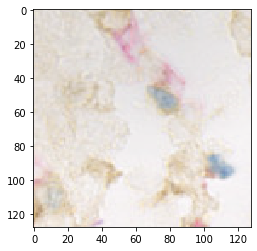

In [18]:
print(len(DATA_objects[0]))

# cv2.imshow('image',DATA_objects[0][44])
# cv2.waitKey(0)
# cv2.destroyAllWindows()
k = DATA_objects[0][44]
plt.imshow(k)
plt.show()

47


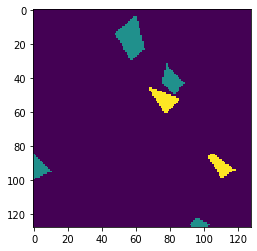

In [14]:
print(len(DATA_objects[1]))
plt.imshow(DATA_objects[1][44])

In [22]:
from Fetch_Prop_graph import Fetch_graph
    
IMAGE = DATA_objects[0]
signal = np.reshape(np.array(IMAGE, dtype=float),[-1,patch_size*patch_size,3])
MASK = DATA_objects[2]
DELTA = DATA_objects[3]
CLASS = DATA_objects[4]                             # 1: blue    2: red

In [31]:
# save ndarray as image
# import imageio
# for img in range(len(IMAGE)):
#     imageio.imwrite('/home/sachin/PycharmProjects/MoNet_DATA/Images/'+'imag_'+str(img)+'.jpg', IMAGE[img])

def iou_score(a, b):
    a = set(a[0])
    b = set(b)
    intersection = a.intersection(b)
    union = a.union(b)
    iou_score_ = len(intersection)/len(union)
    return iou_score_

############################################# Here is the implementation of of the R-CNN data preprocessing tin the graphical domain

################## Dictionary to save node numbers for the N-hop for faster access of the data ####################
with open("/home/sachin/PycharmProjects/MoNet_class_3d/128_20hop_DATA_train_label_Parameter_Nhop_list_128_128.pkl","rb") as fp:
    Nhop_list_dict = pickle.load(fp)

train_graph = []
train_images=[]
train_labels=[]
Parameters = {}

#i = 542
for i in range(len(IMAGE)):
    start = datetime.now()
    image = IMAGE[i]
    mask = MASK[i]
    cls = CLASS[i]
    dlt = DELTA[i]
    dlt = np.sort(np.hstack(dlt))

    ## Find the BBOX coordinate i.e [DELTA, N] as we know the delta value need to find the best N-hop values by IOU computation.
    ## We have the original masks, 1. first go to each pixel 2. find 20 N-hop  3.compare each N-hop with GT Mask and calculate the IOU score 4. Based on IOU score collect Positive and Negative images and labels
    ## 5. for POSITIVE label 1 and Negative label 0
    ## Loop over to (32 x 32 ) image to collect DELTA and their 20 N-hop anchors and compare each Anchor with GT masks to find IOU

    ################## create dictionary to save node numbers for the N-hop for faster access of the data ####################
    '''
#     Nhop_list_dict = {}
#     for delta in range(IMAGE_SHAPE[0]*IMAGE_SHAPE[1]):
#     #for delta in range(128 * 128):
#         Nhop_list_dict[delta] = {}
#         Anc_mask_bbox = main(delta, nhop)                       # this is the main function from BFS_ver2 tio find the N-hop values as a region proposals
#         ## comapre each N-hop with GT masks to find IOU SCORE
#         for Anc_mb in Anc_mask_bbox:
#             Nhop_list_dict[delta][Anc_mask_bbox.index(Anc_mb)] = {}
#             for key, value in Anc_mb.items():
#                 Anc_mask = [int(ik) for ik in value[0][0]]
#                 Anc_bbox = [int(jk) for jk in value[0][1]]
#                 Nhop_list_dict[delta][Anc_mask_bbox.index(Anc_mb)]["Anc_mask_Nhop"] = [key, Anc_mask]
#                 Nhop_list_dict[delta][Anc_mask_bbox.index(Anc_mb)]["Anc_bbox_Nhop"] = [key, Anc_bbox]
#         print("delta:",delta)
#     with open("128_20hop_DATA_train_label_Parameter_Nhop_list_128*128.pkl", "wb") as fp:
#         pickle.dump(Nhop_list_dict, fp)
    '''
    
    redcounter = 0
    bluecounter = 0
    falsecounter = 0
    Parameters[i] = {}
    Parameters[i][0] = []
    Parameters[i][1] = []
    for delta in range(IMAGE_SHAPE[0]*IMAGE_SHAPE[1]):
        # choose only the delta which belongs to the object and find the respective region proposal for traainig
        
        Anc_mask_bbox = Nhop_list_dict[delta]                       # this is the main function from BFS_ver2 tio find the N-hop values as a region proposals
        ## comapre each N-hop with GT masks to find IOU SCORE
        for Anc_mb in Anc_mask_bbox.items():
            Anc_mask = Anc_mb[1]['Anc_mask_Nhop'][1]                                         #[int(ik) for ik in value[0][0]]
            #Anc_bbox = Anc_mb[1]['Anc_bbox_Nhop'][1]                                         #[int(jk) for jk in value[0][1]]
            # compare this N-hop anchor mask with the GT masks and get the IOU score
            # get the original GT mask and find how many objects masks are there for single image
            # check how many object mask are there and go through each object mask
            for num_obj in range(len(mask)):
                if len(mask[num_obj])!= 0:
                    for count, ele in enumerate(mask[num_obj]):
                        # use Summation method to count the IOU score
                        ele_reshape = np.reshape(ele, [-1])
                        assert 2 not in ele_reshape                # to check it is binary mask
                        ele_node = np.where(ele_reshape == 1)
                        #sum_gt_mask = sum(ele_reshape)

                        assert 2 not in ele_reshape[Anc_mask]
                        #pos_sum = sum(np.in1d(Anc_mask,ele_node))
                        #sum_anc_mask = sum(ele_reshape[Anc_mask])

                        match_score = iou_score(ele_node, Anc_mask)

                        #if counter < 30:
                        if (match_score > 0.7): #and (delta in dlt):
                            #print("match score > 0.7 : {}".format(match_score))
                            if redcounter < 300:
                                if cls[num_obj][count] == 'RED':
                                    image_reshape = np.reshape(image, [-1, 3])
                                    Anch_img = image_reshape[Anc_mask]  # store the anchor image
                                    Anch_graph = Fetch_graph(Anc_mask)  # fetch graph for the proposal
                                    train_graph.append(Anch_graph)
                                    train_images.append(Anch_img)
                                    train_labels.append(1)
                                    Parameters[i][num_obj].append({'Delta': delta, 'N-hop': Anc_mb[1]['Anc_mask_Nhop'][0], 'Match-score': match_score})
                                    redcounter += 1
                            if bluecounter < 300:
                                if cls[num_obj][count] == 'BLUE':
                                    image_reshape = np.reshape(image, [-1, 3])
                                    Anch_img = image_reshape[Anc_mask]
                                    Anch_graph = Fetch_graph(Anc_mask)   # fetch graph for the proposal
                                    train_graph.append(Anch_graph)
                                    train_images.append(Anch_img)
                                    train_labels.append(2)
                                    Parameters[i][num_obj].append({'Delta': delta, 'N-hop': Anc_mb[1]['Anc_mask_Nhop'][0], 'Match-score': match_score})
                                    bluecounter += 1
                        #if falsecounter < 30:
                        if (match_score < 0.7) and (count == len(mask[num_obj])-1) and (num_obj==1): # and (Anc_mb[1]['Anc_mask_Nhop'][0]==19):
                            #if falsecounter < 300 and (Anc_mb[1]['Anc_mask_Nhop'][0]==19):
                            #if (Anc_mb[1]['Anc_mask_Nhop'][0]==19):
                            if (falsecounter < 300) or (delta==10240) or (delta==7680):
                                image_reshape = np.reshape(image, [-1, 3])
                                Anch_img = image_reshape[Anc_mask]
                                Anch_graph = Fetch_graph(Anc_mask)   # fetch graph for the proposal
                                train_graph.append(Anch_graph)
                                train_images.append(Anch_img)
                                train_labels.append(0)
                                #Parameters[i][num_obj].append({'Delta': delta, 'N-hop': Anc_mb[1]['Anc_mask_Nhop'][0], 'Match-score': match_score})
                                falsecounter += 1
        #print("delta:",delta)
    print("image {}/{}".format(i,len(IMAGE)))
    DATA_list = [train_images, train_labels, train_graph, Parameters]
    with open("./tmp/dataset/300_aug_DATA_train_label_Parameter_ver11_NotOnlyDELTA_New.pkl", "wb") as fp:
        pickle.dump(DATA_list, fp)
    print("End Time : {}".format(datetime.now()))
    print("Execution time : {}".format(datetime.now() - start))
    print("End")
print("FINISH")


image 0/282
End Time : 2021-03-02 18:11:12.788941
Execution time : 0:03:13.040202
End
image 1/282
End Time : 2021-03-02 18:14:26.285573
Execution time : 0:03:13.496607
End
image 2/282
End Time : 2021-03-02 18:17:33.576028
Execution time : 0:03:07.290422
End
image 3/282
End Time : 2021-03-02 18:20:41.990922
Execution time : 0:03:08.414871
End
image 4/282
End Time : 2021-03-02 18:23:49.457685
Execution time : 0:03:07.466732
End
image 5/282
End Time : 2021-03-02 18:26:54.616830
Execution time : 0:03:05.159116
End
image 6/282
End Time : 2021-03-02 18:28:58.407963
Execution time : 0:02:03.791103
End
image 7/282
End Time : 2021-03-02 18:31:02.377269
Execution time : 0:02:03.968987
End
image 8/282
End Time : 2021-03-02 18:33:10.086702
Execution time : 0:02:07.709493
End
image 9/282
End Time : 2021-03-02 18:35:32.059313
Execution time : 0:02:21.972456
End
image 10/282
End Time : 2021-03-02 18:38:03.856157
Execution time : 0:02:31.938033
End
image 11/282
End Time : 2021-03-02 18:40:25.260061
Ex

image 95/282
End Time : 2021-03-02 23:31:03.427185
Execution time : 0:02:35.856608
End
image 96/282
End Time : 2021-03-02 23:43:31.345895
Execution time : 0:12:27.918209
End
image 97/282
End Time : 2021-03-02 23:49:44.879363
Execution time : 0:06:13.533383
End
image 98/282
End Time : 2021-03-02 23:56:00.168743
Execution time : 0:06:15.289275
End
image 99/282
End Time : 2021-03-03 00:02:17.700097
Execution time : 0:06:17.531279
End
image 100/282
End Time : 2021-03-03 00:14:51.927188
Execution time : 0:12:34.226845
End
image 101/282
End Time : 2021-03-03 00:27:23.060268
Execution time : 0:12:31.133217
End
image 102/282
End Time : 2021-03-03 00:33:19.913201
Execution time : 0:05:56.852978
End
image 103/282
End Time : 2021-03-03 00:39:19.716841
Execution time : 0:05:59.803386
End
image 104/282
End Time : 2021-03-03 00:45:18.711330
Execution time : 0:05:58.994267
End
image 105/282
End Time : 2021-03-03 00:51:10.217957
Execution time : 0:05:51.506608
End
image 106/282
End Time : 2021-03-03 0

End Time : 2021-03-03 06:20:56.552073
Execution time : 0:03:57.381518
End
image 189/282
End Time : 2021-03-03 06:24:56.734505
Execution time : 0:04:00.182239
End
image 190/282
End Time : 2021-03-03 06:28:50.812510
Execution time : 0:03:54.078096
End
image 191/282
End Time : 2021-03-03 06:32:37.500425
Execution time : 0:03:46.687708
End
image 192/282
End Time : 2021-03-03 06:34:54.263489
Execution time : 0:02:16.763155
End
image 193/282
End Time : 2021-03-03 06:43:38.125397
Execution time : 0:08:43.861433
End
image 194/282
End Time : 2021-03-03 06:45:52.661025
Execution time : 0:02:14.534578
End
image 195/282
End Time : 2021-03-03 06:48:08.789597
Execution time : 0:02:16.128644
End
image 196/282
End Time : 2021-03-03 06:50:25.164843
Execution time : 0:02:16.375377
End
image 197/282
End Time : 2021-03-03 06:52:41.982514
Execution time : 0:02:16.817331
End
image 198/282
End Time : 2021-03-03 07:01:43.048362
Execution time : 0:09:01.065955
End
image 199/282
End Time : 2021-03-03 07:04:20.2

FINISH


In [ ]:
########################################################################################
~~~~~~~~~~~~~~~~~~~~~~~~~~ Graph Convolution Network ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
########################################################################################

In [2]:
# Load data
# Load the cell region proposal data as a graph features, labels
with open("/home/sachin/PycharmProjects/DATASETS/tmp/dataset/DATA/Graph_proposal_ver_11_New.pkl", "rb") as fp:
    DATA = pickle.load(fp)

print("DATA len",len(DATA[0]))
A_train, A_test, x_train, x_test, y_train, y_test = nclass_to_binclass(DATA)

# One_hot labels for the binary classification
y_train = tf.one_hot(y_train, 3).numpy()
y_test = tf.one_hot(y_test, 3).numpy()

DATA len 15974
number of unique elements LABELS : (array([0, 1, 2]), array([10800,   678,  4496]))
(2, 3)


In [3]:
len(x_train)

14376

In [4]:
# Train model   
############# functional model
with tf.device('/GPU:0'):
    #@tf.function
    class Cust_minCutPool(tf.keras.layers.Layer):
        def __init__(self,ratio):
            self.ratio = ratio
            super(Cust_minCutPool, self).__init__()

        def call(self, input):
            self.Nd = input[0].shape[0]
            X_1, A_1 = MinCutPool(self.Nd // self.ratio)([input[0], input[1]])

            return X_1, A_1

    class BasicGraphNet(tf.keras.Model):
        # @tf.function
        def __init__(self):
            super(BasicGraphNet, self).__init__()

            self.G1 = GraphAttention(32, activation='relu', kernel_regularizer=reg)

            self.G2 = GraphAttention(32, activation='relu', kernel_regularizer=reg)
            #self.G1 = GraphAttention(32, activation='relu')
            #self.G2 = GraphAttention(32, activation='relu')
            #self.G1 = GraphAttention(32)
            #self.G2 = GraphAttention(32)
            self.cust_layer_1 = Cust_minCutPool(2)
            self.cust_layer_2 = Cust_minCutPool(4)
            
            self.gloSumPool = GlobalSumPool()
            
            self.B1 = tf.keras.layers.BatchNormalization(trainable=True)
            self.A1 = tf.keras.layers.Activation('relu')
            self.pool_1 = GlobalAttentionPool(32)
            self.pool_2 = GlobalAttentionPool(n_classes)
            self.A2 = tf.keras.layers.Activation('softmax')


            self.TopKpool = TopKPool(ratio=0.5)

            self.F1 = tf.keras.layers.Flatten(name='flatten')
            self.O1 = tf.keras.layers.Dense(64, kernel_regularizer=reg, name='dense_100')
            self.D1 = tf.keras.layers.Dropout(0.5, name='dropout')
            #self.O2 = tf.keras.layers.Dense(n_classes, activation='softmax', kernel_regularizer=reg, name='dense_2')
            self.O2 = tf.keras.layers.Dense(n_classes, activation='softmax', name='dense_2')

        # @tf.function
        def call(self, input_tensor, training=True):

            x = self.G1([input_tensor[0], input_tensor[1]])
            x = self.G2([x, input_tensor[1]])
            #x, A = self.cust_layer_1([x, input_tensor[1]])
            #x, A = self.cust_layer_2([x, A])

            #x = self.B1(x)
            #x = self.A1(x)

            x = self.pool_1(x)
            #x, A = self.TopKpool(x, input_tensor[1])
                        
            #x = self.O1(x)
            #x = self.D1(x, training)
            #x = self.O2(x)
            #x = self.pool_2(x)
            #x = self.A2(x)
            
            #x = self.gloSumPool(x)
                                    
            #x = tf.expand_dims(x, axis=0)
            #x = self.F1(x)
            #x = self.D1(x, training)
            #x = self.O1(x)
            #x = self.D2(x, training)
            #x = self.O2(x)
            x = self.pool_2(x)
            x = self.A2(x)

            return x

        # @tf.function
        def _compute_gradients(self, tape, tensor, var_list):
            grads = tape.gradient(tensor, var_list)
            # print(type(grads))
            # print(type(var_list))
            return [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(var_list, grads)]

        #@tf.function
        def train_step(self, A_train, x_train, y_train):
            '''
                This is a TensorFlow function, run once for each epoch for the
                whole input. We move forward first, then calculate gradients
                with Gradient Tape to move backwards.
            '''
            for i in range(len(x_train)):
                # determine starting and ending slice indexes for the current
                # batch
                start = i * 1
                end = start + 1
                # take a step
                A = A_train[start:end][0]
                X = x_train[start:end][0]
                y = y_train[start:end]

                with tf.GradientTape(watch_accessed_variables=True) as tape:
                    # make a prediction using the model and then calculate the
                    # loss
                    # extract graph from y and make a list with x
                    # tape.watch(self.trainable_variables)
                    # grp = tf.convert_to_tensor(grp)
                    
                    X = (X / 255.0).astype(np.float32)
                    
                    y_pred = model([X, A], training=True)
                    #print("y_pred:",y_pred)
                    y_true = y[0]
                    #y_true = tf.one_hot(y_true, depth=2)
                    #print("y_true:",y_true)
                    loss = loss_object(y_true, y_pred[0])
                    # print("loss",loss)
                variables = self.trainable_variables
                # calculate the gradients using our tape and then update the
                # model weights

                # tmp_var = tf.constant((self.trainable_variables[0]).numpy())
                # grads = self._compute_gradients(tape, loss, variables)
                grads = tape.gradient(loss, variables)
                # print(grads)
                opt.apply_gradients(zip(grads, variables))

                #uncomment if not working propoerly
                metricLoss(loss)
                metricsAcc(y_true, y_pred[0])

                # comment if not working properly
                #metricLoss.update_state(loss)
                #metricsAcc.update_state(y_true, y_pred)

                #if (i == 10000 or i == 50000 or i == 90000):
                #    print(i)

            # Loss and accuracy
            train_loss_results.append(metricLoss.result())
            train_accuracy_results.append(metricsAcc.result())


        #@tf.function
        def test_step(self, A_val, x_val, y_val):
            '''
                This is a TensorFlow function, run once for each epoch for the
                whole input.
            '''
            for i in range(len(x_val)):
                # determine starting and ending slice indexes for the current
                # batch
                start = i * 1
                end = start + 1
                # take a step
                A_ = A_val[start:end][0]
                X_ = x_val[start:end][0]
                y_ = y_val[start:end]

                X_ = (X_ / 255.0).astype(np.float32)              
                
                y_pred_ = model([X_, A_], training=False)

                y_true_ = y_[0]

                t_loss = loss_object(y_true_, y_pred_[0])

                #uncomment if not working propoerly
                test_loss(t_loss)
                test_metric(y_true_, y_pred_[0])

                # comment if not working properly
                #test_loss.update_state(t_loss)
                #test_metric.update_state(y_true_, y_pred_)

                #if (i == 100 or i == 500 or i == 900):
                #    print(i)

            test_loss_results.append(test_loss.result())
            test_accuracy_results.append(test_metric.result())


        # @tf.function
        def fit(self, A_train, A_val, x_train, x_val, y_train, y_val, epochs):
            '''
                This fit function runs training and testing.
            '''
            for epoch in range(epochs):
                start = datetime.now()
                # print("Epoch {}: Start Time {}".format(epoch,start))

                self.train_step(A_train, x_train, y_train)
                self.test_step(A_val, x_val, y_val)
                template = '\t Epoch {}, Train Loss: {:.4f}, Train Accuracy: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.4f}'
                print(template.format(epoch + 1,
                                      metricLoss.result(),
                                      metricsAcc.result(), test_loss.result(), test_metric.result()))

                checkpoint.save(file_prefix=checkpoint_prefix)
                
                with train_writer.as_default():
                    tf.summary.scalar('accuracy', metricsAcc.result(), step=epoch)
                    tf.summary.scalar('loss', metricLoss.result(), step=epoch)
  
                with test_writer.as_default():
                    tf.summary.scalar('accuracy', test_metric.result(), step=epoch)
                    tf.summary.scalar('loss', test_loss.result(), step=epoch)

                # Reset the metrics for the next epoch
                metricLoss.reset_states()
                metricsAcc.reset_states()

                test_loss.reset_states()
                test_metric.reset_states()

                #print("End Time : {}".format(datetime.now()))
                #print("Execution time : {}".format(datetime.now() - start))

                
#### Main execution ##########
## Use K-fold cross validation
from sklearn.model_selection import KFold

dropout = 0.2
momentum = 0.9

n_classes = 3  # Number of classes
reg = l2(1e-5)  # Regularization rate for l2
learning_rate = 5e-5  # Learning rate for Adam
epochs = 20  # Number of training epochs
batch_size = 1  # Batch size
es_patience = 10
decay_steps = 20000

kf = KFold(n_splits=5)
iteration = 1
for train_index, test_index in kf.split(x_train):
    A_train_k, A_val_k = A_train[train_index], A_train[test_index]
    x_train_k, x_val_k = x_train[train_index], x_train[test_index]
    y_train_k, y_val_k = y_train[train_index], y_train[test_index]

    print("K-Fold: {}...".format(iteration))
    start = datetime.now()
    print("Start Time {}".format(start))
    with tf.device('/GPU:0'):
        
        train_loss_results = []
        train_accuracy_results = []

        test_loss_results = []
        test_accuracy_results = []

        # model = create_model()
        model = BasicGraphNet()
        # model = MoNet(d=d, n_gaussian=n_gaussian, n_hidden=32, batch_size=batch_size, trainable=True)

        # Hyperparameters

        # For this implementation, batch_size needs to be a divisor of the number of samples (x_train = 51000 samples)


        ## learningi rate schedular, to change learning rate during training based on the model leanring
        #learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=learning_rate,
        #                      decay_steps=decay_steps,
        #                      end_learning_rate=0.0)

        #boundaries = [9, 19]
        #values = [0.1, 0.01, 0.001]

        #learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
        #opt = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn)

        opt = tf.keras.optimizers.Adam(lr=learning_rate)
        #opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum = momentum)      
        #opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, momentum=momentum)

        # Make a loss object
        #loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
        #loss_object = tf.keras.losses.CategoricalCrossentropy()
        loss_object = tfa.losses.SigmoidFocalCrossEntropy(gamma = 2.0, alpha = 4.0)
        #loss_object = tfa.losses.SigmoidFocalCrossEntropy()
        #loss_object = focal_loss
        # loss_object = tf.keras.losses.sparse_categorical_crossentropy

        metricLoss = tf.keras.metrics.Mean(name='train_loss')
        #metricsAcc = tf.keras.metrics.SparseCategoricalAccuracy()
        metricsAcc = tf.keras.metrics.CategoricalAccuracy()


        # Specify metrics for testing
        test_loss = tf.keras.metrics.Mean(name='test_loss')
        #test_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
        test_metric = tf.keras.metrics.CategoricalAccuracy()
        

        checkpoint_directory = "./tmp/Color/Test_1_three_class/KFold_"+str(iteration)+"/training_checkpoints"
        checkpoint_prefix = os.path.join(checkpoint_directory, ".ckpt")

        checkpoint = tf.train.Checkpoint(optimizer=opt, model=model)
        #checkpoint.restore(tf.train.latest_checkpoint(checkpoint_directory))

        current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
        log_dir = 'logs/' + current_time
        
        train_writer = tf.summary.create_file_writer(os.path.join(log_dir, "train"))
        test_writer = tf.summary.create_file_writer(os.path.join(log_dir, "test"))
        # x_train=tf.convert_to_tensor(x_train)
        # y_train=tf.convert_to_tensor(y_train)
        
        model.fit(A_train_k, A_val_k, x_train_k, x_val_k, y_train_k, y_val_k, epochs=epochs)
        
        iteration = iteration + 1
        
        print("End K-Fold...")
        print("Execution time : {}".format(datetime.now() - start))

print("Finish K-Fold Training")

K-Fold: 1...
Start Time 2020-09-12 22:26:08.113024
	 Epoch 1, Train Loss: 0.5935, Train Accuracy: 0.7901, Val Loss: 0.4448, Val Accuracy: 0.8369
	 Epoch 2, Train Loss: 0.3621, Train Accuracy: 0.8382, Val Loss: 0.2994, Val Accuracy: 0.8526
	 Epoch 3, Train Loss: 0.2733, Train Accuracy: 0.8644, Val Loss: 0.2984, Val Accuracy: 0.8150
	 Epoch 4, Train Loss: 0.2273, Train Accuracy: 0.8756, Val Loss: 0.4435, Val Accuracy: 0.8178
	 Epoch 5, Train Loss: 0.2025, Train Accuracy: 0.8834, Val Loss: 0.5435, Val Accuracy: 0.8077
	 Epoch 6, Train Loss: 0.1739, Train Accuracy: 0.8930, Val Loss: 0.4624, Val Accuracy: 0.8063
	 Epoch 7, Train Loss: 0.1482, Train Accuracy: 0.8999, Val Loss: 0.3416, Val Accuracy: 0.8032
	 Epoch 8, Train Loss: 0.1330, Train Accuracy: 0.9046, Val Loss: 0.3302, Val Accuracy: 0.7893
	 Epoch 9, Train Loss: 0.1216, Train Accuracy: 0.9064, Val Loss: 0.3310, Val Accuracy: 0.7761
	 Epoch 10, Train Loss: 0.1189, Train Accuracy: 0.9083, Val Loss: 0.3819, Val Accuracy: 0.7232
	 Epoch 

	 Epoch 4, Train Loss: 0.1717, Train Accuracy: 0.9015, Val Loss: 0.1780, Val Accuracy: 0.9047
	 Epoch 5, Train Loss: 0.1533, Train Accuracy: 0.9058, Val Loss: 0.1834, Val Accuracy: 0.8960
	 Epoch 6, Train Loss: 0.1375, Train Accuracy: 0.9091, Val Loss: 0.2182, Val Accuracy: 0.8431
	 Epoch 7, Train Loss: 0.1333, Train Accuracy: 0.9116, Val Loss: 0.1564, Val Accuracy: 0.8911
	 Epoch 8, Train Loss: 0.1247, Train Accuracy: 0.9121, Val Loss: 0.1868, Val Accuracy: 0.8595
	 Epoch 9, Train Loss: 0.1162, Train Accuracy: 0.9144, Val Loss: 0.1851, Val Accuracy: 0.8477
	 Epoch 10, Train Loss: 0.1130, Train Accuracy: 0.9146, Val Loss: 0.2169, Val Accuracy: 0.8327
	 Epoch 11, Train Loss: 0.1103, Train Accuracy: 0.9151, Val Loss: 0.2403, Val Accuracy: 0.8146
	 Epoch 12, Train Loss: 0.1033, Train Accuracy: 0.9177, Val Loss: 0.2060, Val Accuracy: 0.8393
	 Epoch 13, Train Loss: 0.1077, Train Accuracy: 0.9184, Val Loss: 0.1641, Val Accuracy: 0.8734
	 Epoch 14, Train Loss: 0.0979, Train Accuracy: 0.9168, 

In [5]:
####### choose best model for the inference
with tf.device('/GPU:0'):
        
    for iteration in range(1,6,1):
        New_model = BasicGraphNet()
        New_checkpoint_directory = "./tmp/Color/Test_1_three_class/KFold_"+str(iteration)+"/training_checkpoints"
        New_checkpoint_prefix = os.path.join(checkpoint_directory, ".ckpt")

        New_checkpoint = tf.train.Checkpoint(optimizer=opt, model=New_model)
        New_checkpoint.restore(tf.train.latest_checkpoint(New_checkpoint_directory))


        ################### INFERENCE #######################
        ################### INFERENCE #######################
        y_inf = []
        pred_inf = []

        print("INFERENCE RESULT #########")
        for i in range(len(x_test)):
            # determine starting and ending slice indexes for the current
            # batch
            start = i * 1
            end = start + 1

            # take a step
            A_ = A_test[start:end][0]
            X_ = x_test[start:end][0]
            y_ = y_test[start:end]

            X_ = (X_ / 255).astype(np.float32)

            y_pred_ = New_model([X_, A_], training=False)
            #print(y_pred_)
            y_true_ = y_[0]

            y_inf.append(np.argmax(y_true_))
            pred_inf.append(np.argmax(y_pred_))

        m = tf.keras.metrics.Accuracy()
        m.update_state(y_inf, pred_inf)
        print("Model {} Inferennnce accuracy: {}".format(iteration, m.result().numpy()))

INFERENCE RESULT #########
Model 1 Inferennnce accuracy: 0.5688360333442688
INFERENCE RESULT #########
Model 2 Inferennnce accuracy: 0.5782227516174316
INFERENCE RESULT #########
Model 3 Inferennnce accuracy: 0.8535669445991516
INFERENCE RESULT #########
Model 4 Inferennnce accuracy: 0.6539424061775208
INFERENCE RESULT #########
Model 5 Inferennnce accuracy: 0.5688360333442688


In [6]:
## Load image data for the inference testing and object detection
with open("/home/sachin/PycharmProjects/DATASETS/tmp/dataset/DATA/DATA/pathes_47.pkl","rb") as fp:
    DATA = pickle.load(fp)

import matplotlib.pyplot as plt
from PIL import Image

IMAGE = DATA[0]
signal = np.reshape(np.array(IMAGE, dtype=float), [-1, 128 * 128, 3])
MASK = DATA[2]
DELTA = DATA[3]
CLASS = DATA[4]

im_num = 40
image = IMAGE[im_num]
mask = MASK[im_num]
cls = CLASS[im_num]
delta = DELTA[im_num]

# plt.imshow(image)
# plt.show()

image = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)
# cv2.imshow('image',image_noise)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

print("RED delta", delta[0])
print("BLUE delta", delta[1])

RED delta [14071, 12125, 1951, 161]
BLUE delta [15896, 12351, 560]


In [ ]:
######## code for the inference ###################
##### do inference ####
IMAGE_SHAPE = [128, 128]
# with open("/home/sachin/PycharmProjects/MoNet_DATA/MoNet_pkl_files/test_data_128*128.pkl", "rb") as fp:
#     test_data_128 = pickle.load(fp)
pred_sig = np.reshape(image.astype(np.float32), [-1, IMAGE_SHAPE[0] * IMAGE_SHAPE[1], 3])
pred_sig = (pred_sig/255.0).astype(np.float32)

# pred_sig = np.reshape(np.asarray(Image.open("/home/sachin/PycharmProjects/Cell_Graph_MASK-rcnn/Image_364.png"),dtype=float),[-1,3])

# this dictionary list is the image size 128 x 128
with open("/home/sachin/PycharmProjects/MoNet_class_3d/128_20hop_DATA_train_label_Parameter_Nhop_list_128_128.pkl","rb") as fp:
    Nhop_list_dict = pickle.load(fp)

## function to find the adjacency binary matrix of the graph

def adj_mat(gr):
    Adjacency = []
    source = gr[0]
    dest = gr[1]

    dest_new = np.copy(dest)

    # replace source nodes with unique nodes starting from 0
    src_unq_idx_cnt = np.unique(source, return_index=True, return_inverse=True, return_counts=True)
    g = [a for a in range(len(src_unq_idx_cnt[0]))]
    g_idx = src_unq_idx_cnt[2]
    g1 = np.array(g)[g_idx.astype(int)]

    dst_unq_idx_cnt = np.unique(dest, return_index=True, return_inverse=True, return_counts=True)
    dst_unq = dst_unq_idx_cnt[0]
    for du in dst_unq:
        idx = np.where(dest == du)

        idx_s = np.where(source == du)
        real_s = g1[idx_s[0]]

        # put actual value to the destination
        dest_new[idx[0]] = real_s

    new_gr = [g1, dest_new]
    new_gr = np.array(new_gr)

    # create a binary adjaceny matrix using csr_matrix
    N = len(src_unq_idx_cnt[0])  # num of nodes
    value = np.ones(len(new_gr[0]))

    Adj = csr_matrix((value, (new_gr[0], new_gr[1])), shape=(N, N), dtype=np.float32).toarray()

    Adjacency = np.array(Adj)

    return Adjacency


start = datetime.now()
print("Start Time", start)
with tf.device('/GPU:0'):
    Object_pred_1 = []
    Object_pred_2 = []

    Non_object = []
    Threshold_blue = 0.50
    for delta in range(IMAGE_SHAPE[0] * IMAGE_SHAPE[1]):
        Anc_mask_bbox = Nhop_list_dict[delta]
        # remove nhops for faster processing: keep, nhop no. 7, 11, 17
        #Anc_mask_bbox = [Anc_mask_bbox[9],Anc_mask_bbox[13], Anc_mask_bbox[14], Anc_mask_bbox[15]]
        #Anc_mask_bbox = [Anc_mask_bbox[7],Anc_mask_bbox[10], Anc_mask_bbox[12], Anc_mask_bbox[14]]
        #Anc_mask_bbox = [Anc_mask_bbox[8],Anc_mask_bbox[10]]
        #Anc_mask_bbox = [Anc_mask_bbox[8]]

        for Anc_mb in Anc_mask_bbox.items():
            Anc_mask = Anc_mb[1]['Anc_mask_Nhop'][1]  # [int(ik for ik in value[0][0]]
            Anc_bbox = Anc_mb[1]['Anc_bbox_Nhop'][1]
            # print("Anc_mask",Anc_mask)
            Anch_graph = Fetch_graph(Anc_mask)

            ############## anchor from the signal
            X_pred = pred_sig[0][Anc_mask]           
            A_pred = adj_mat(Anch_graph)

            pred = New_model([X_pred, A_pred], training=False)
            #pred = model([X_pred, A_pred])
            #print("pred",pred)
            #print("pred[0]",pred[0])

            pred_index = np.argmax(pred[0], axis=0)
            # print("pred_idx",pred_index)

            match_score = pred[0][pred_index]
            # print("match_score",match_score)
            if (match_score > Threshold_blue) and (pred_index == 1):
                bbox = [delta, Anc_mb[1]['Anc_bbox_Nhop'][0], Anc_mask, Anch_graph, match_score]
                Object_pred_1.append(bbox)
                
            elif (match_score > Threshold_blue) and (pred_index == 2):
                bbox = [delta, Anc_mb[1]['Anc_bbox_Nhop'][0], Anc_mask, Anch_graph, match_score]
                Object_pred_2.append(bbox)
        #             else:
        #                 bbox = [delta, Anc_mb['Anc_bbox_Nhop'][0], Anc_mask, Anch_graph, match_score]
        #                 Non_object.append(bbox)

        if (delta % 1000) == 0:
            print("delta:", delta)
object_pred = [Object_pred_1, Object_pred_2]
print("End Time : {}".format(datetime.now()))
print("Execution time : {}".format(datetime.now() - start))

Start Time 2020-09-12 20:11:32.650345
delta: 0
delta: 1000
delta: 2000
delta: 3000
delta: 4000
delta: 5000
delta: 6000
delta: 7000
delta: 8000
delta: 9000
delta: 10000
delta: 11000
delta: 12000
delta: 13000
delta: 14000


In [ ]:
############### below are the results for 9th model Test_2_focal_loss_three_class_model_2.pkl
with open('./Anchor_box/Test_5_focal_loss_three_class_model_5.pkl', 'wb') as f:
    pickle.dump(object_pred, f)
len(object_pred[1])

In [ ]:
len(object_pred[0])

In [ ]:
######################################
#### Non maximum seperation
import itertools
data_arr = np.array(object_pred[0])
L = [list(v) for k,v in itertools.groupby(data_arr, lambda x: x[0])]

B = []
for i in range(len(L)):
    B.append(L[i][-1])
B = np.array(B)

def iou_score(a, b):
    a = set(a)
    b = set(b)
    intersection = a.intersection(b)
    union = a.union(b)
    iou_score_ = len(intersection)/len(union)
    return iou_score_

D = []
Threshold = 0.50
while len(B)!= 0:
    #index of the max score
    m = np.argmax([v.numpy() for v in B[:,-1]])
    # find actual bbox
    M = B[m]
    D.append(M)
    B = np.delete(B, m, axis=0)

    for obj in range((len(B)-1), -1, -1):
        if iou_score(M[2], B[obj][2]) >= Threshold:
            B = np.delete(B, obj, axis=0)
print("finish")

In [ ]:
######################################
################## please do experimentation on this #######################
#### Display output of the object detection #####
# with open("mask_rcnn_pred.pkl", "rb") as fp:
#     pred_seg = pickle.load(fp)
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from pygsp import graphs

G1 = graphs.Grid2d(128, 128)  # make sure x[0] having dimension nVertices x nChannel
# G1.compute_differential_operator()
# G1.compute_fourier_basis()
# U = tf.convert_to_tensor(G.U, dtype=tf.float32)
G1.plotting['vertex_size'] = 20

sign = np.reshape(pred_sig[0], (128, 128, 3))
sign = sign.astype(np.uint8)
plt.imshow(sign)

img_gray = np.reshape(rgb2gray(sign), [-1])

############## plot the object #############
ax = plt.figure(figsize=[15, 15])
G1.plot_signal(img_gray, ax=plt.gca())

for i in range(0, len(D)):
    bbox = D[i][2]
    #print(bbox)
    # best_bbox = bbox[-1:]

    # seg_mask = np.reshape(pred_seg.numpy(),[-1])
    # seg_mask_node_blue = np.where(seg_mask == 1)
    # seg_mask_coord_blue = G1.coords[seg_mask_node_blue]

    # seg_mask_node_red = np.where(seg_mask == 2)
    # seg_mask_coord_red = G1.coords[seg_mask_node_red]

    b_coord = np.array(bbox)
    poly_coord = G1.coords[b_coord]
    hull = ConvexHull(poly_coord, qhull_options='QJ')

    #ax = plt.figure(figsize=[5, 5])
    #G1.plot_signal(img_gray, ax=plt.gca())

    for simplex in hull.simplices:
        plt.plot(poly_coord[simplex, 0], poly_coord[simplex, 1], 'r-')
    
    # plt.plot(seg_mask_coord_blue[:,0], seg_mask_coord_blue[:,1], 'ro')
    # plt.plot(seg_mask_coord_red[:,0], seg_mask_coord_red[:,1], 'bo')
    #plt.plot(poly_coord[hull.vertices,0], poly_coord[hull.vertices,1], 'r--', lw=2)

plt.show()

print("Finish Segmentation")

print("Finish")